In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import numpy as np
import random

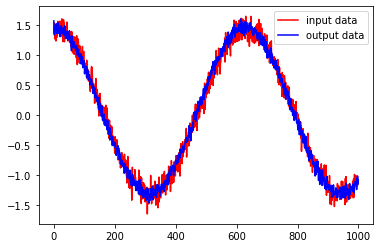

In [23]:
n_timesteps_in = 35 # length of input sequence
n_timesteps_out = 30 # length of output sequence
seq_len = max(n_timesteps_in, n_timesteps_out)

n_features_in = 1
n_features_out = 1
time_series_length = 1000
t = np.linspace(0, 10, time_series_length)
ts_input = np.sin(t) / 7 + 3 * np.cos(t) + 0.25 * np.random.standard_normal(size=time_series_length)
ts_output = np.cos(t) / 2 + 4 * np.cos(t) + 0.2 * np.random.standard_normal(size=time_series_length)
# normalize the data
ts_norm_input = (ts_input - np.mean(ts_input)) / np.std(ts_input)
ts_norm_output = (ts_output - np.mean(ts_output)) / np.std(ts_output)
plt.plot(ts_norm_input, 'r', label = 'input data')
plt.plot(ts_norm_output,'b', label = 'output data')

plt.legend()

In [24]:
#train_size = int(len(ts_input) * 0.9)
#test_size = len(ts_input) - train_size

#train_input, test_input = ts_norm_input[0:train_size], ts_norm_input[train_size:len(ts_input)]
#train_output, test_output = ts_norm_output[0:train_size], ts_norm_output[train_size:len(ts_input)]
train_input, test_input = train_test_split(ts_norm_input, train_size=0.9, shuffle=False)
train_output, test_output = train_test_split(ts_norm_output, train_size=0.9, shuffle=False)


In [25]:
def create_dataset():
    train_input_data, train_output_data = [], []
    for i in range(1_000):
        rand_ind_train = random.randint(0, len(train_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_train:rand_ind_train+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_train:rand_ind_train+n_timesteps_out]
        train_input_data.append(input_seq)
        train_output_data.append(output_seq)
    test_input_data, test_output_data = [], []   
    for i in range(5):
        rand_ind_test = random.randint(0, len(test_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_test:rand_ind_test+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_test:rand_ind_test+n_timesteps_out]
        test_input_data.append(input_seq)
        test_output_data.append(output_seq)
    return np.array(train_input_data), np.array(train_output_data), np.array(test_input_data), np.array(test_output_data)

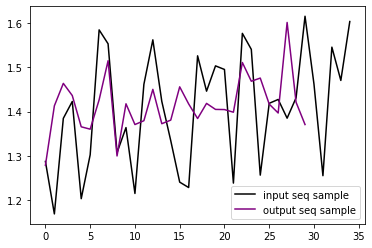

In [26]:
train_input_data, train_output_data, test_input_data, test_output_data = create_dataset()
plt.plot(train_input_data[0], 'black', label='input seq sample')
plt.plot(train_output_data[0], 'purple', label='output seq sample')
plt.legend()

In [27]:
train_input_data = np.reshape(train_input_data, (train_input_data.shape[0], n_timesteps_in, n_features_in))
train_output_data = np.reshape(train_output_data, (train_input_data.shape[0], n_timesteps_out, n_features_out))

test_input_data = np.reshape(test_input_data, (test_input_data.shape[0], n_timesteps_in, n_features_in))
test_output_data = np.reshape(test_output_data, (test_input_data.shape[0], n_timesteps_out, n_features_out))

In [28]:
n_units = 128

encoder_inputs = keras.Input(shape=(n_timesteps_in, n_features_in))
encoder = keras.layers.LSTM(n_units, return_sequences=False, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

# Set up the decoder, using 'encoder_states' as initial state.
decoder_inputs = keras.Input(shape=(n_timesteps_out, n_features_out))
decoder_lstm =  keras.layers.LSTM(n_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(n_features_out, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [29]:
model.compile(optimizer='adam', loss='mse')
decoder_inputs = np.zeros(train_output_data.shape)

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

model.fit([train_input_data, decoder_inputs], train_output_data,
          epochs=100, batch_size=64, validation_split=0.2, callbacks = my_callbacks, verbose=2)

Epoch 1/100
13/13 - 6s - loss: 0.4771 - val_loss: 0.0455 - 6s/epoch - 437ms/step
Epoch 2/100
13/13 - 1s - loss: 0.0605 - val_loss: 0.0542 - 1s/epoch - 82ms/step
Epoch 3/100
13/13 - 1s - loss: 0.0388 - val_loss: 0.0295 - 1s/epoch - 97ms/step
Epoch 4/100
13/13 - 1s - loss: 0.0276 - val_loss: 0.0251 - 811ms/epoch - 62ms/step
Epoch 5/100
13/13 - 1s - loss: 0.0246 - val_loss: 0.0213 - 966ms/epoch - 74ms/step
Epoch 6/100
13/13 - 1s - loss: 0.0221 - val_loss: 0.0198 - 1s/epoch - 101ms/step
Epoch 7/100
13/13 - 1s - loss: 0.0203 - val_loss: 0.0179 - 1s/epoch - 103ms/step
Epoch 8/100
13/13 - 1s - loss: 0.0190 - val_loss: 0.0158 - 1s/epoch - 114ms/step
Epoch 9/100
13/13 - 2s - loss: 0.0163 - val_loss: 0.0138 - 2s/epoch - 165ms/step
Epoch 10/100
13/13 - 2s - loss: 0.0149 - val_loss: 0.0130 - 2s/epoch - 125ms/step
Epoch 11/100
13/13 - 2s - loss: 0.0135 - val_loss: 0.0117 - 2s/epoch - 118ms/step
Epoch 12/100
13/13 - 1s - loss: 0.0128 - val_loss: 0.0120 - 1s/epoch - 112ms/step
Epoch 13/100
13/13 - 1s

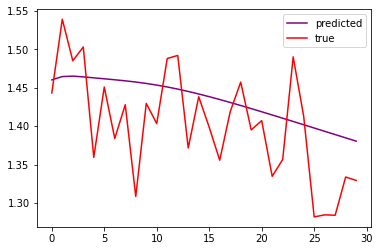

In [30]:
decoder_inputs = np.zeros(test_output_data.shape)
y_pred = model.predict([test_input_data, decoder_inputs])
plt.plot(y_pred[0], 'purple', label = 'predicted')
plt.plot(test_output_data[0], 'r', label = 'true')

plt.legend()